# Costas Signal Processing
## By Terry Bondy, VA3TYB

In [1]:
printf(strftime ("Last updated: %A %e %B %Y", localtime (time ())))

Last updated: Saturday  1 February 2020

1. Want to be able to process signals across a BW just a bit bigger than 100 kHz.
1. Want to be able to send 8 X 8 Costas signal using a radio with a BW 200 Hz - 2600 Hz.

frLow = 200
frHigh = 2600
bwRadio = frHigh - frLow
costasN = 8
deltaFcostas = bwRadio/costasN

To meet the Nyquist criteria, sampling rate > 2 * BWchannel. BWchannel is:

In [6]:
BWchannel = 100000

BWchannel =  100000


...and twice that is:

In [7]:
BWchannel * 2

ans =  200000


For the Costas signal, one subpulse period is 1/deltaFcostas

In [8]:
1/deltaFcostas

ans =  0.0033333


For processing, we want the number of samples to be processed in a bit period to be a power of two greater than

In [9]:
BWchannel * 2/deltaFcostas

ans =  666.67


or

In [13]:
pulseSamples = pow2(ceil(log2(BWchannel * 2/deltaFcostas)))

pulseSamples =  1024


In [14]:
sampleRate = pulseSamples * deltaFcostas

sampleRate =  307200


...which meets the Nyquist criteria nicely with lots of headroom.

To ensure continous phase between subpulses, the lowest freq. subpulse should be the same as deltaFcostas. So, the Costas signal baseband frequencies are:

In [15]:
costasFreq = deltaFcostas:deltaFcostas:deltaFcostas * costasN

costasFreq =

    300    600    900   1200   1500   1800   2100   2400



Lets simulate trying to determine the offset frequency and offset time that a Costas signal is received. We'll use a reference signal of 0 Hz offset and 0 s time, just so wwe can find out what the processing offsets are.

First build up the reference signal

In [23]:
RefSig = [ 0 ];
for costasFreq = deltaFcostas:deltaFcostas:deltaFcostas * costasN
  Time = 0:1/sampleRate:1/deltaFcostas;
  SubPulse = i * exp(i*2*pi*costasFreq*Time);
  # Add all but the first
  RefSig = [RefSig SubPulse(2:end)];
endfor

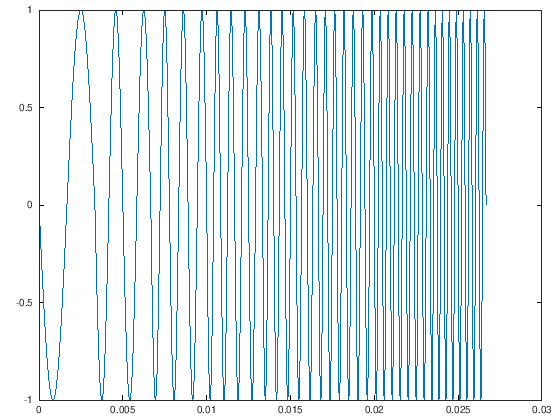

In [36]:
plot(0:1/sampleRate:costasN/deltaFcostas, RefSig)

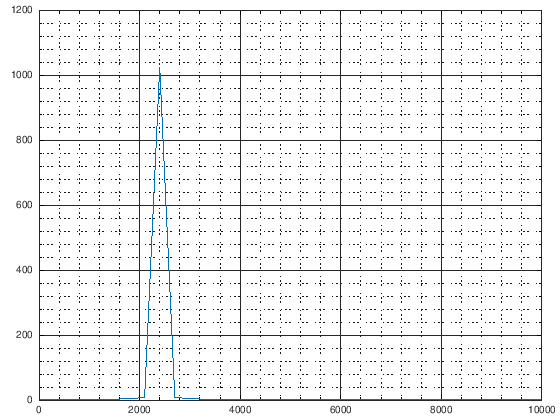

In [31]:
Freq = linspace(0, sampleRate, columns(SubPulse));
plot(Freq, abs(fft(SubPulse)))
grid on
grid minor
axis([0 10000])